/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 1 



Episode took 2.1083046620005916




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 2 



Episode took 1.6722161649995542




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 3 



Episode took 1.6214420319993224




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 4 



Episode took 1.9223221859992918




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 5 



Episode took 2.852657162000469




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 6 



Episode took 2.951048360000641




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 7 



Episode took 2.797587661001671




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 8 



Episode took 2.807019905998459




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 9 



Episode took 2.7999685160011722




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 10 



Episode took 2.7753904630008037




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 11 



Episode took 2.8216269349995855




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 12 



Episode took 2.7974132760009525




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 13 



Episode took 2.908589269998629




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 14 



Episode took 2.9138286959987454




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 15 



Episode took 2.7064040599998407




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 16 



Episode took 2.6705898709988105




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 17 



Episode took 2.8658414030014683




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 18 



Episode took 2.6461341049998737




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 19 



Episode took 2.812601577999885




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 20 



Episode took 2.940178711000044




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 21 



Episode took 3.0229386539995176




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 22 



Episode took 2.8660668440006702




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 23 



Episode took 2.821431454998674




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 24 



Episode took 2.745716875000653




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 25 



Episode took 2.8104319169997325




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 26 



Episode took 2.8937672810006916




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 27 



Episode took 2.998188408000715




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 28 



Episode took 2.884841477000009




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 29 



Episode took 2.787712138999268




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 30 



Episode took 2.8782245940001303




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 31 



Episode took 2.8389359620014147




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 32 



Episode took 2.960088486999666




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 33 



Episode took 2.9254476300011447




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 34 



Episode took 2.87615305700092




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 35 



Episode took 2.900911429000189




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 36 



Episode took 2.6906194530001812




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 37 



Episode took 2.8863874819999182




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 38 



Episode took 2.887601579999682




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 39 



Episode took 2.8914639630002057




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 40 



Episode took 2.9276512739997997




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 41 



Episode took 2.8659547139995993




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 42 



Episode took 2.7682781929997873




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 43 



Episode took 2.906448856001589




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 44 



Episode took 2.8469401499987725




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 45 



Episode took 2.845432323998466




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 46 



Episode took 2.8482059449997905




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 47 



Episode took 2.952460335000069




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 48 



Episode took 2.9984569030002604




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 49 



Episode took 2.919525731000249




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 50 



Episode took 2.926039549000052




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 51 



Episode took 2.9151527100002568




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 52 



Episode took 2.856290177000119




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 53 



Episode took 2.7011196879993804




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 54 



Episode took 2.9355304760010767




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 55 



Episode took 2.908915356001671




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 56 



Episode took 2.9636235299985856




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 57 



Episode took 2.829169753000315




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 58 



Episode took 2.9350502000015695




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 59 



Episode took 2.9114825439992273




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 60 



Episode took 2.8510771419987577




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 61 



Episode took 2.8147340399991663




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 62 



Episode took 2.8435253190000367




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 63 



Episode took 2.7817179470002884




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 64 



Episode took 2.7792608959989593




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 65 



Episode took 2.6606727100006538




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 66 



Episode took 2.8506005340004776




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 67 



Episode took 2.91824665599961




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 68 



Episode took 2.843569282000317




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 69 



Episode took 2.7043908199993894




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 70 



Episode took 3.046308979000969




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 71 



Episode took 3.070385555998655




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 72 



Episode took 3.0639012310002727




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 73 



Episode took 2.906300126000133




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 74 



Episode took 2.879153313000643




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 75 



Episode took 2.9154104059998645




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 76 



Episode took 2.9180978149997827




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 77 



Episode took 3.085771891001059




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 78 



Episode took 3.1314731519996712




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 79 



Episode took 3.3050341369998932




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 80 



Episode took 3.107587661999787




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 81 



Episode took 3.4043782919998193




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 82 



Episode took 3.181839492999643




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 83 



Episode took 3.0421871449998434




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 84 



Episode took 2.965197060000719




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 85 



Episode took 2.9869005759992433




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 86 



Episode took 3.095699961999344




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 87 



Episode took 3.0069099140000617




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 88 



Episode took 2.8849444500010577




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 89 



Episode took 2.9971466699989833




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 90 



Episode took 2.8542027130006318




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 91 



Episode took 2.8747997259997646




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 92 



Episode took 2.8409000350002316




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 93 



Episode took 2.827788993001377




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 94 



Episode took 2.9886004569998477




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 95 



Episode took 2.8692458329987858




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 96 



Episode took 2.845949317999839




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 97 



Episode took 2.8751766059995134




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 98 



Episode took 3.058654592001403




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 99 



Episode took 2.8381867649986816




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 100 



Episode took 2.8196033779986465




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 101 



Episode took 2.943221273000745




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 102 



Episode took 2.8983544139991864




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 103 



Episode took 2.8966772460007633




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 104 



Episode took 2.9049158110010467




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 105 



Episode took 2.990253316000235




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 106 



Episode took 2.913390136000089




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 107 



Episode took 2.9148670979993767




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 108 



Episode took 2.920411735000016




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 109 



Episode took 2.8202915000001667




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 110 



Episode took 2.9430985010003496




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 111 



Episode took 2.821128937001049




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 112 



Episode took 2.876045814000463




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 113 



Episode took 2.8650559189991327




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 114 



Episode took 2.839311016001375




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 115 



Episode took 2.8740881549983897




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 116 



Episode took 2.9378030040006706




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 117 



Episode took 2.882603469000969




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 118 



Episode took 2.9853883830000996




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 119 



Episode took 3.0073069160007435




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 120 



Episode took 2.8876895510002214




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 121 



Episode took 2.8550150499995652




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 122 



Episode took 2.890138029000809




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 123 



Episode took 2.9815308369998093




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 124 



Episode took 2.8478231169992796




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 125 



Episode took 2.928080404000866




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 126 



Episode took 2.906075303999387




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 127 



Episode took 3.007131559001209




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 128 



Episode took 2.943177556999217




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 129 



Episode took 2.952279188999455




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 130 



Episode took 2.99732605600002




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 131 



Episode took 3.1348619119999057




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 132 



Episode took 3.05378114099949




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 133 



Episode took 3.069060227000591




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 134 



Episode took 3.100639352000144




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 135 



Episode took 2.8309918329996435




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 136 



Episode took 3.0535704220001207




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 137 



Episode took 3.0410417880011664




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 138 



Episode took 2.965730992000317




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 139 



Episode took 3.17086512700007




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 140 



Episode took 3.0834331380010553




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 141 



Episode took 3.0950228349993267




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 142 



Episode took 3.1051902460003475




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 143 



Episode took 2.9882268869987456




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 144 



Episode took 2.9326628069993603




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 145 



Episode took 2.9927505159994325




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 146 



Episode took 2.838212986000144




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 147 



Episode took 2.839097359999869




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 148 



Episode took 2.748471848999543




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 149 



Episode took 2.8925795720006136




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 150 



Episode took 3.129706416000772




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 151 



Episode took 3.1337344969997503




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilk

Episode 152 



Episode took 3.338500698999269




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 153 



Episode took 3.3312831840012223




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 154 



Episode took 3.0888399520008534




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 155 



Episode took 2.903443076000258




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 156 



Episode took 2.7790581959998235




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 157 



Episode took 3.0778817539994634




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 158 



Episode took 3.0412746609999886




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 159 



Episode took 2.809377638001024




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 160 



Episode took 2.8706812590007758




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 161 



Episode took 2.90825478700026




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 162 



Episode took 3.0397620069998084




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 163 



Episode took 3.210756426999069




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 164 



Episode took 3.102171439000813




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 165 



Episode took 3.09217427799922




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 166 



Episode took 3.0682399259985687




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 167 



Episode took 3.1249026149998826




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)


Episode 168 



Episode took 2.935821888000646




/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/deep_rl_ga/ga_env.py:320: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.curr_best_fitness / self.prev_best_fitness)

KeyboardInterrupt



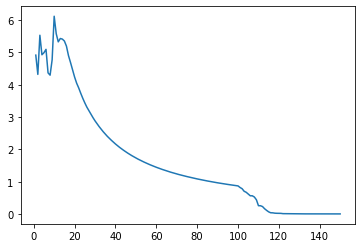

In [1]:
import time
%matplotlib inline
from deep_rl_ga.ga_env import GeneticAlgorithmEnv
from deep_rl_ga.agent import Agent
from deep_rl_ga.memory import Experience, ReplayMemory, extract_tensors
from deep_rl_ga.strategy import EpsilonGreedyStrategy
from deep_rl_ga.network import DQN
from deep_rl_ga.qvalues import QValues

from deap import benchmarks
from deap import tools

import torch
import torch.optim as optim
import torch.nn.functional as F

from itertools import count
import random

import numpy as np

import matplotlib.pyplot as plt
from IPython import display

from deap import creator
from typing import List
import itertools
# import cuml
# import cudf
# import cupy
import datetime
import os
from deep_rl_ga.diversity import (
    Clusterer,
    fitness_max_mean_ratio_diversity,
    fitness_mean_min_ratio_diversity,
    gene_mean_std_diversity,
    gene_mean_unique_ratio_diversity,
    number_of_clusters_diversity,
    selBestPossible,
    selWorstPossible,
)

# Genetic algorithm params
IND_SIZE = 3
LOW_BOUND = -5.12
UP_BOUND = 5.12
FITNESS_FUNCTION = benchmarks.rastrigin
SEARCH_SPACE_CENTER = np.array([(UP_BOUND - LOW_BOUND / 2) for _ in range(IND_SIZE)])
SEARCH_SPACE_DIAMETER = np.linalg.norm(np.array([UP_BOUND for _ in range(IND_SIZE)]) - np.array([LOW_BOUND for _ in range(IND_SIZE)]))

INITIAL_POPULATION_SIZE = 150

# Crossover + Mutation params
MATING_RATE = 0.3
INDIVIDUAL_MUTATION_RATE = 0.3
ATTRIBUTE_MUTATION_RATE = 0.3

MATING_RATE_VALUES = [0.05 * i for i in range(1, 20)]
INDIVIDUAL_MUTATION_RATE_VALUES = [0.05 * i for i in range(1, 20)]

# Selection params
TOURNAMENT_SIZE = 3
TOP_BEST_SIZE = 25

TOURNAMENT_SIZE_VALUES = [10]
TOP_BEST_SIZE_VALUES = [25]

MAX_EVALS = 10_000

RANDOM_SEED = 127

random.seed(
    RANDOM_SEED
    )
np.random.seed(
    RANDOM_SEED
    )

ACTIONS_SEL = list(itertools.chain(
    [{'function': tools.selTournament, 'tournsize': tsize} for tsize in TOURNAMENT_SIZE_VALUES],
    # [{'function': lambda population, k: tools.selWorst(population, TOP_BEST_SIZE)}],
    [{'function': selWorstPossible}],  # fill the population with the WORST individuals - this is the action the network should avoid
    [{'function': selBestPossible, 'top_n': TOP_BEST_SIZE}],  # fill the population with the BEST individuals
    # [{'function': lambda population, k: population}],  # no-op
))

ACTIONS_CX = [
    {'function': tools.cxBlend, 'alpha': UP_BOUND},
    # {'function': tools.cxTwoPoint},
    # {'function': lambda ind1, ind2: (ind1, ind2)},  # no-op
]

ACTIONS_MU = [
    {'function': tools.mutGaussian, 'mu': 0, 'sigma': 1, 'indpb': ATTRIBUTE_MUTATION_RATE},
    # {'function': tools.mutShuffleIndexes, 'indpb': ATTRIBUTE_MUTATION_RATE},
    # {'function': lambda ind: (ind,)},  # no-op
]


CLUSTERER = Clusterer()

N_CLUSTERS = 10

N_STACKED_STATES = 5

# class RapidsClusteringMethod:
#     def __init__(self, n_clusters, random_state):
#         self.model = cuml.cluster.KMeans(init='k-means||', n_clusters=n_clusters, random_state=random_state)
#
#     def fit_predict(self, X):
#         device_data = cudf.DataFrame(X)
#         return self.model.fit_predict(device_data).to_numpy()

STAT_FUNCTIONS = [
    ("clusters_of_multiple_fns", CLUSTERER.clusters_of_fns([
        fitness_max_mean_ratio_diversity,
        fitness_mean_min_ratio_diversity,
        gene_mean_std_diversity,
        gene_mean_unique_ratio_diversity,
        lambda p: len(p) / INITIAL_POPULATION_SIZE,  # Cluster population size as part of initial population size
        lambda p: np.linalg.norm(np.mean(p, axis=0) - SEARCH_SPACE_CENTER) / SEARCH_SPACE_DIAMETER,  # Cluster centroid distance from the middle of search space; normalized by search space diameter
    ], n_clusters=N_CLUSTERS, random_seed=RANDOM_SEED)),
]

# Neural network params
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100_000
lr = 3e-4
num_episodes = 1_000

curr_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = GeneticAlgorithmEnv(
    num_dims=IND_SIZE,
    low_bound=LOW_BOUND,
    up_bound=UP_BOUND,
    fitness_fn=benchmarks.rastrigin,
    max_evals=MAX_EVALS,
    initial_population_size=INITIAL_POPULATION_SIZE,
    actions_sel=ACTIONS_SEL,
    actions_cx=ACTIONS_CX,
    actions_mu=ACTIONS_MU,
    stat_functions=STAT_FUNCTIONS,
    clusterer=CLUSTERER,
    device=curr_device,
    number_of_stacked_states=N_STACKED_STATES,
)


# Saving model data
save_every_num_episodes = 150
curr_datetime = datetime.datetime.utcnow()
save_dir_path = f'../{curr_datetime.day}-{curr_datetime.month}-{curr_datetime.year}_{curr_datetime.hour}-{curr_datetime.minute}_{em.number_of_stacked_states}-states_{em.num_actions_available()}-actions_seed-{RANDOM_SEED}'
os.mkdir(save_dir_path)

# RL setup
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), curr_device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_num_state_features(), em.num_actions_available()).to(curr_device)
target_net = DQN(em.get_num_state_features(), em.num_actions_available()).to(curr_device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_best_fitnesses = []
for episode in range(num_episodes):
    start_episode = time.perf_counter()
    em.reset()
    state = em.get_state()

    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)  # this is a performance bottleneck, it takes 0.1seconds, almost 100% of the time required for a single timestep
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))


        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences, curr_device)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states, curr_device)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            # TODO: This should be a value that we want to track across episodes, e.x. number of generations before global optimum was found
            episode_best_fitnesses.append(em.hof[0].fitness.values[0])
            print('Episode', len(episode_best_fitnesses), '\n')
            # plot(episode_best_fitnesses, 100)
            break
    stop_episode = time.perf_counter()
    print(f'\n\nEpisode took {stop_episode - start_episode}\n\n')

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Checkpoint model data
    if episode > 0 and episode % save_every_num_episodes == 0:
        # Parameters
        torch.save(policy_net, os.path.join(save_dir_path, f'policy_net_{episode}_episodes'))
        torch.save(target_net, os.path.join(save_dir_path, f'target_net_{episode}_episodes'))

        # Performance
        moving_averages = [np.mean(episode_best_fitnesses[i-100:i]) if i > 99 else np.mean(episode_best_fitnesses[:i]) for i, _ in enumerate(episode_best_fitnesses)]
        plt.plot(moving_averages)
        plt.savefig(os.path.join(save_dir_path, f'moving_averages_{episode}_episodes.png'))

    # TODO: This should be a value that we want to track across episodes, e.x. number of generations before global optimum was found
    # if get_moving_average(100, episode_best_fitnesses)[-1] <= 0.0001:
    #     break